<a href="https://colab.research.google.com/github/rangelokk/Diplom/blob/main/Version_archive/RN50/V1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Residual Networks

Welcome to another tutorial! Now we will learn how to build very deep convolutional networks, using Residual Networks (ResNets).

**In this assignment, we will:**
- Implement the basic building blocks of ResNets.
- Put together these building blocks to implement and train a state-of-the-art neural network for image classification.

Let's run the cell below to load the required packages:

In [ ]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import cv2
import numpy as np
from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D
from keras.models import Model, load_model
from keras.initializers import glorot_uniform
from keras.utils import plot_model
from IPython.display import SVG
#from keras.utils.vis_utils import model_to_dot
from tensorflow.keras.utils import plot_model
import keras.backend as K
import tensorflow as tf

In [ ]:
import kagglehub
import numpy as np
import seaborn as sns
import pandas as pd
import imgaug.augmenters as iaa
from keras.utils import to_categorical
import imageio
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, mean_squared_error, mean_absolute_error
from sklearn.linear_model import SGDClassifier
from PIL import Image

In [ ]:
ROWS = 64
COLS = 64
CHANNELS = 3
CLASSES = 7

# Загрузка данных

### Загрузка данных

In [ ]:
# Download latest version
path = kagglehub.dataset_download("kmader/skin-cancer-mnist-ham10000")

print("Path to dataset files:", path)

100%|██████████| 5.20G/5.20G [02:13<00:00, 41.9MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/kmader/skin-cancer-mnist-ham10000/versions/2


In [ ]:
data = pd.read_csv(path + "/HAM10000_metadata.csv")
data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [ ]:
def read_image(file_path):
  img = cv2.imread(path + '/HAM10000_images_part_2/'+file_path+'.jpg', cv2.IMREAD_COLOR)
  if (img is None):
    img = cv2.imread(path + '/HAM10000_images_part_1/'+file_path+'.jpg', cv2.IMREAD_COLOR)
  return cv2.resize(img, (ROWS, COLS), interpolation=cv2.INTER_CUBIC)

In [ ]:
data['Image'] = data['image_id'].apply(read_image)
data['age'].fillna((data['age'].median()), inplace=True)
data

<ipython-input-9-94a310f2e3e8>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['age'].fillna((data['age'].median()), inplace=True)


,lesion_id,image_id,dx,dx_type,age,sex,localization,Image
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,"[[[198, 156, 193], [194, 153, 188], [190, 145,..."
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,"[[[25, 12, 21], [27, 14, 23], [42, 25, 36], [7..."
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,"[[[138, 129, 185], [148, 134, 191], [160, 147,..."
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,"[[[17, 10, 23], [30, 20, 34], [47, 35, 63], [6..."
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,"[[[118, 95, 140], [139, 114, 159], [163, 134, ..."
...,...,...,...,...,...,...,...,...
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen,"[[[163, 152, 165], [156, 142, 159], [142, 123,..."
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen,"[[[1, 6, 4], [9, 9, 9], [8, 7, 9], [25, 28, 32..."
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen,"[[[109, 108, 118], [124, 127, 143], [114, 118,..."
10013,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face,"[[[145, 128, 156], [129, 109, 154], [157, 134,..."


In [ ]:
X_t, Test = train_test_split(data, test_size=0.2, random_state=42)
Train, Val = train_test_split(X_t, test_size=0.25, random_state=42)

In [ ]:
Train

,lesion_id,image_id,dx,dx_type,age,sex,localization,Image
482,HAM_0005146,ISIC_0030346,bkl,histo,60.0,male,face,"[[[100, 86, 127], [104, 97, 133], [103, 97, 13..."
7123,HAM_0007477,ISIC_0032007,nv,histo,25.0,male,back,"[[[201, 201, 231], [207, 207, 231], [208, 209,..."
6581,HAM_0007071,ISIC_0030449,nv,follow_up,35.0,female,trunk,"[[[169, 158, 235], [165, 154, 235], [172, 154,..."
6991,HAM_0001767,ISIC_0025812,nv,histo,50.0,female,lower extremity,"[[[165, 145, 164], [168, 146, 165], [165, 142,..."
6333,HAM_0003907,ISIC_0027587,nv,follow_up,60.0,male,upper extremity,"[[[144, 127, 218], [141, 125, 219], [126, 111,..."
...,...,...,...,...,...,...,...,...
9564,HAM_0004197,ISIC_0033467,nv,consensus,40.0,female,unknown,"[[[216, 208, 219], [219, 210, 221], [225, 214,..."
4666,HAM_0002304,ISIC_0024648,nv,follow_up,55.0,female,lower extremity,"[[[198, 172, 247], [198, 172, 245], [198, 174,..."
9382,HAM_0005712,ISIC_0025101,nv,consensus,5.0,female,foot,"[[[183, 146, 180], [184, 146, 182], [185, 144,..."
4070,HAM_0001206,ISIC_0031320,nv,follow_up,55.0,male,abdomen,"[[[165, 143, 225], [166, 140, 226], [164, 144,..."


In [ ]:
Train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6009 entries, 482 to 7570
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lesion_id     6009 non-null   object 
 1   image_id      6009 non-null   object 
 2   dx            6009 non-null   object 
 3   dx_type       6009 non-null   object 
 4   age           6009 non-null   float64
 5   sex           6009 non-null   object 
 6   localization  6009 non-null   object 
 7   Image         6009 non-null   object 
dtypes: float64(1), object(7)
memory usage: 422.5+ KB


### Аугментация

<Axes: xlabel='dx', ylabel='percent'>

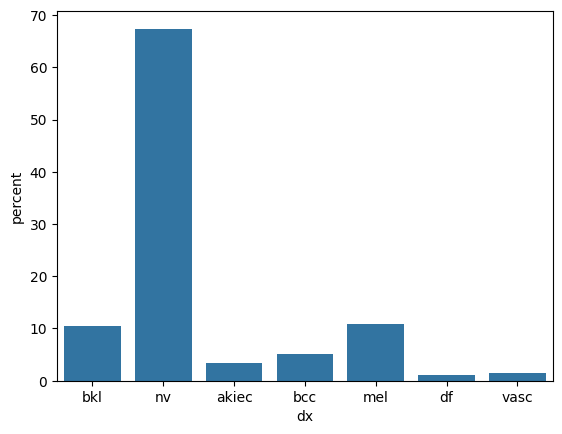

In [ ]:
sns.countplot(Train, x="dx", stat="percent")

In [ ]:
def Augmentation(dat, apply_dx):
  new_data = pd.DataFrame()
  rotations = [
      iaa.Affine(rotate=90),
      iaa.Affine(rotate=180),
      iaa.Affine(rotate=270)
      ]
  for index, line in dat.iterrows():
    if(line['dx']!='nv'):
      image_np = np.array(line['Image'])
      augmented_images = [(rotation(image=image_np)) for rotation in rotations]
      for aug_image in augmented_images:
        new_line = line.copy()
        new_line['Image'] = aug_image
        new_data = pd.concat([new_data, new_line.to_frame().T], ignore_index=True)
  return new_data

In [ ]:
Aug_Data=Augmentation(Train, 'apply_dx')
Aug_Data

,lesion_id,image_id,dx,dx_type,age,sex,localization,Image
0,HAM_0005146,ISIC_0030346,bkl,histo,60.0,male,face,"[[[109, 94, 126], [102, 90, 122], [101, 90, 12..."
1,HAM_0005146,ISIC_0030346,bkl,histo,60.0,male,face,"[[[102, 95, 118], [99, 93, 119], [104, 98, 121..."
2,HAM_0005146,ISIC_0030346,bkl,histo,60.0,male,face,"[[[111, 109, 131], [111, 98, 122], [120, 115, ..."
3,HAM_0006085,ISIC_0033322,bkl,histo,85.0,female,face,"[[[136, 119, 131], [136, 119, 132], [142, 124,..."
4,HAM_0006085,ISIC_0033322,bkl,histo,85.0,female,face,"[[[47, 40, 50], [71, 61, 77], [93, 78, 92], [1..."
...,...,...,...,...,...,...,...,...
5872,HAM_0002761,ISIC_0029068,bkl,histo,60.0,male,face,"[[[11, 13, 23], [14, 15, 25], [31, 30, 50], [5..."
5873,HAM_0002761,ISIC_0029068,bkl,histo,60.0,male,face,"[[[37, 36, 52], [39, 37, 60], [48, 43, 68], [4..."
5874,HAM_0003435,ISIC_0031350,mel,histo,60.0,male,back,"[[[126, 111, 160], [127, 125, 167], [131, 121,..."
5875,HAM_0003435,ISIC_0031350,mel,histo,60.0,male,back,"[[[119, 105, 146], [115, 105, 147], [117, 108,..."


In [ ]:
Train=pd.concat([Train, Aug_Data], ignore_index=True)
Train

,lesion_id,image_id,dx,dx_type,age,sex,localization,Image
0,HAM_0005146,ISIC_0030346,bkl,histo,60.0,male,face,"[[[100, 86, 127], [104, 97, 133], [103, 97, 13..."
1,HAM_0007477,ISIC_0032007,nv,histo,25.0,male,back,"[[[201, 201, 231], [207, 207, 231], [208, 209,..."
2,HAM_0007071,ISIC_0030449,nv,follow_up,35.0,female,trunk,"[[[169, 158, 235], [165, 154, 235], [172, 154,..."
3,HAM_0001767,ISIC_0025812,nv,histo,50.0,female,lower extremity,"[[[165, 145, 164], [168, 146, 165], [165, 142,..."
4,HAM_0003907,ISIC_0027587,nv,follow_up,60.0,male,upper extremity,"[[[144, 127, 218], [141, 125, 219], [126, 111,..."
...,...,...,...,...,...,...,...,...
11881,HAM_0002761,ISIC_0029068,bkl,histo,60.0,male,face,"[[[11, 13, 23], [14, 15, 25], [31, 30, 50], [5..."
11882,HAM_0002761,ISIC_0029068,bkl,histo,60.0,male,face,"[[[37, 36, 52], [39, 37, 60], [48, 43, 68], [4..."
11883,HAM_0003435,ISIC_0031350,mel,histo,60.0,male,back,"[[[126, 111, 160], [127, 125, 167], [131, 121,..."
11884,HAM_0003435,ISIC_0031350,mel,histo,60.0,male,back,"[[[119, 105, 146], [115, 105, 147], [117, 108,..."


In [ ]:
Train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11886 entries, 0 to 11885
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   lesion_id     11886 non-null  object
 1   image_id      11886 non-null  object
 2   dx            11886 non-null  object
 3   dx_type       11886 non-null  object
 4   age           11886 non-null  object
 5   sex           11886 non-null  object
 6   localization  11886 non-null  object
 7   Image         11886 non-null  object
dtypes: object(8)
memory usage: 743.0+ KB


<Axes: xlabel='dx', ylabel='percent'>

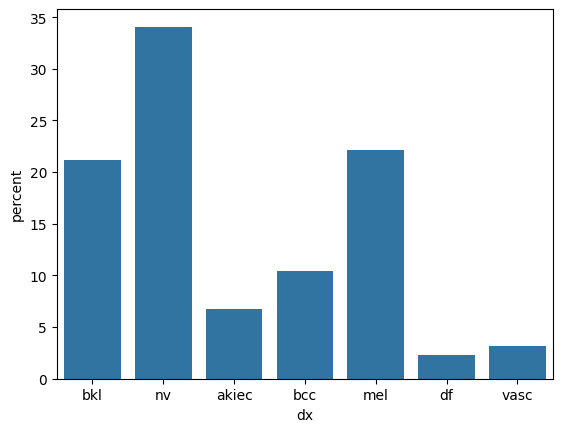

In [ ]:
sns.countplot(Train, x="dx", stat="percent")

Run the following code to normalize the dataset and learn about its shapes:

### Сборка данных

In [ ]:
def prepare_data(images):
    m = len(images)
    print(m)
    X = np.zeros((m, ROWS ,COLS, CHANNELS), dtype=np.uint8)
    for i, image_file in enumerate(images):
        X[i,:] = image_file
    return X

In [ ]:
X_train = (prepare_data(Train['Image'])/255.).astype(np.float16)
X_test = (prepare_data(Test['Image'])/255.).astype(np.float16)
X_val = (prepare_data(Val['Image'])/255.).astype(np.float16)
print(X_train.dtype)

11886
2003
2003
float16


In [ ]:
class_labels = {
    'akiec': 0,
    'bcc': 1,
    'bkl': 2,
    'df': 3,
    'nv': 4,
    'vasc': 5,
    'mel': 6
}
Y_train = to_categorical(Train['dx'].replace(class_labels), num_classes=CLASSES)
Y_test = to_categorical(Test['dx'].replace(class_labels), num_classes=CLASSES)
Y_val = to_categorical(Val['dx'].replace(class_labels), num_classes=CLASSES)

<ipython-input-23-22ead99fef41>:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  Y_train = to_categorical(Train['dx'].replace(class_labels), num_classes=CLASSES)
<ipython-input-23-22ead99fef41>:11: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  Y_test = to_categorical(Test['dx'].replace(class_labels), num_classes=CLASSES)
<ipython-input-23-22ead99fef41>:12: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=F

In [ ]:
A_test = (Test['age']/85.).to_numpy().reshape(-1, 1).astype(np.float16)
A_train = (Train['age']/85.).to_numpy().reshape(-1, 1).astype(np.float16)
A_val = (Val['age']/85.).to_numpy().reshape(-1, 1).astype(np.float16)

In [ ]:

print ("number of training examples =", X_train.shape[0])
print ("number of test examples =", X_test.shape[0])
print ("X_train shape:", X_train.shape)
print ("Y_train shape:", Y_train.shape)
print ("A_train shape:", A_train.shape)
print ("X_test shape:", X_test.shape)
print ("Y_test shape:", Y_test.shape)
print ("A_test shape:", A_test.shape)
print ("X_val shape:", X_val.shape)
print ("Y_val shape:", Y_val.shape)
print ("A_val shape:", A_val.shape)

number of training examples = 11886
number of test examples = 2003
X_train shape: (11886, 64, 64, 3)
Y_train shape: (11886, 7)
A_train shape: (11886, 1)
X_test shape: (2003, 64, 64, 3)
Y_test shape: (2003, 7)
A_test shape: (2003, 1)
X_val shape: (2003, 64, 64, 3)
Y_val shape: (2003, 7)
A_val shape: (2003, 1)


In [ ]:
Train['age'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 11886 entries, 0 to 11885
Series name: age
Non-Null Count  Dtype 
--------------  ----- 
11886 non-null  object
dtypes: object(1)
memory usage: 93.0+ KB


# 2 - Building a Residual Network

In ResNets, a "shortcut" or a "skip connection" allows the gradient to be directly backpropagated to earlier layers:  

<img src="images/skip_connection.png" style="width:650px;height:200px;">

Two main types of blocks are used in a ResNet, depending mainly on whether the input/output dimensions are same or different. We are going to implement both of them.

#### Why do Skip Connections work?
- They mitigate the problem of vanishing gradient by allowing this alternate shortcut path for gradient to flow through
- They allow the model to learn an identity function which ensures that the higher layer will perform at least as good as the lower layer, and not worse

### 2.1 - The identity block

We'll implement identity block, in which the skip connection "skips over" 3 hidden layers rather than 2 layers. It looks like this:

<img src="images/Identity_block2.png" style="width:650px;height:150px;">


**Arguments**:<br>
    X - input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)<br>
    f - integer, specifying the shape of the middle CONV's window for the main path<br>
    filters - python list of integers, defining the number of filters in the CONV layers of the main path<br>
    stage - integer, used to name the layers, depending on their position in the network<br>
    block - string/character, used to name the layers, depending on their position in the network<br>

**Returns**:<br>
    X - output of the identity block, tensor of shape (n_H, n_W, n_C)<br>

In [ ]:
def identity_block(X, f, filters, stage, block):
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    # Retrieve Filters
    F1, F2, F3 = filters

    # Save the input value. We'll need this later to add back to the main path.
    X_shortcut = X

    # First component of main path
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    # Second component of main path
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

In [ ]:
# Создание входного тензора
A_prev = tf.keras.Input(shape=(4, 4, 6))  # Указываем размер входа (вместо placeholder)

# Применяем identity_block
A = identity_block(A_prev, f=2, filters=[2, 4, 6], stage=1, block='a')

# Создаем модель
model = tf.keras.Model(inputs=A_prev, outputs=A)

# Генерируем случайный ввод
X = np.random.randn(3, 4, 4, 6).astype(np.float32)

# Получаем выход модели
out = model(X)

# Печатаем результат
print("out = ", out[1][0])  # Измените индексы в зависимости от нужного выхода

out =  tf.Tensor(
[[0.         1.8055722  0.         0.         0.         1.88707   ]
 [0.9441187  0.303465   2.5582197  0.         0.         0.        ]
 [1.0846184  1.2566423  0.         0.36539194 0.         2.6675406 ]
 [1.8115664  0.         1.3974621  0.         0.         0.        ]], shape=(4, 6), dtype=float32)


## 2.2 - The convolutional block

The ResNet "convolutional block" is the other type of block:

<img src="images/Identity_block3.png" style="width:650px;height:150px;">

    
**Arguments**:<br>
    X - input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)<br>
    f - integer, specifying the shape of the middle CONV's window for the main path<br>
    filters - python list of integers, defining the number of filters in the CONV layers of the main path<br>
    stage - integer, used to name the layers, depending on their position in the network<br>
    block - string/character, used to name the layers, depending on their position in the network<br>
    s - Integer, specifying the stride to be used<br>

**Returns**:<br>
    X - output of the convolutional block, tensor of shape (n_H, n_W, n_C)

In [ ]:
def convolutional_block(X, f, filters, stage, block, s = 2):
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    # Retrieve Filters
    F1, F2, F3 = filters

    # Save the input value
    X_shortcut = X


    ##### MAIN PATH #####
    # First component of main path
    X = Conv2D(F1, (1, 1), strides = (s,s), name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    # Second component of main path
    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path
    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)


    ##### SHORTCUT PATH ####
    X_shortcut = Conv2D(F3, (1, 1), strides = (s,s), name = conv_name_base + '1', kernel_initializer = glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

In [ ]:
# Создание входного тензора
A_prev = tf.keras.Input(shape=(4, 4, 6))  # Указываем размер входа (вместо placeholder)

# Применяем identity_block
A = identity_block(A_prev, f=2, filters=[2, 4, 6], stage=1, block='a')

# Создаем модель
model = tf.keras.Model(inputs=A_prev, outputs=A)

# Генерируем случайный ввод
X = np.random.randn(3, 4, 4, 6).astype(np.float32)

# Получаем выход модели
out = model(X)

# Печатаем результат
print("out = ", out[1][0])  # Измените индексы в зависимости от нужного выхода

out =  tf.Tensor(
[[0.         0.         0.         0.6183703  1.0240599  2.1661747 ]
 [0.11094189 0.9080489  0.         0.         0.02672026 1.5273252 ]
 [0.         0.56141376 0.         0.         0.         0.        ]
 [0.         0.         0.7107007  0.         0.91150063 0.        ]], shape=(4, 6), dtype=float32)


## 3 - Building our first ResNet model (50 layers)

We now have the necessary blocks to build a very deep ResNet. The following figure describes in detail the architecture of this neural network. "ID BLOCK" in the diagram stands for "Identity block," and "ID BLOCK x3" means you should stack 3 identity blocks together.

<img src="images/ResNet-50.png" style="width:850px;height:150px;">

The details of this ResNet-50 model are:
- Zero-padding pads the input with a pad of (3,3)
- Stage 1:
    - The 2D Convolution has 64 filters of shape (7,7) and uses a stride of (2,2). Its name is "conv1".
    - BatchNorm is applied to the channels axis of the input.
    - MaxPooling uses a (3,3) window and a (2,2) stride.
- Stage 2:
    - The convolutional block uses three set of filters of size [64,64,256], "f" is 3, "s" is 1 and the block is "a".
    - The 2 identity blocks use three set of filters of size [64,64,256], "f" is 3 and the blocks are "b" and "c".
- Stage 3:
    - The convolutional block uses three set of filters of size [128,128,512], "f" is 3, "s" is 2 and the block is "a".
    - The 3 identity blocks use three set of filters of size [128,128,512], "f" is 3 and the blocks are "b", "c" and "d".
- Stage 4:
    - The convolutional block uses three set of filters of size [256, 256, 1024], "f" is 3, "s" is 2 and the block is "a".
    - The 5 identity blocks use three set of filters of size [256, 256, 1024], "f" is 3 and the blocks are "b", "c", "d", "e" and "f".
- Stage 5:
    - The convolutional block uses three set of filters of size [512, 512, 2048], "f" is 3, "s" is 2 and the block is "a".
    - The 2 identity blocks use three set of filters of size [512, 512, 2048], "f" is 3 and the blocks are "b" and "c".
- The 2D Average Pooling uses a window of shape (2,2) and its name is "avg_pool".
- The flatten doesn't have any hyperparameters or name.
- The Fully Connected (Dense) layer reduces its input to the number of classes using a softmax activation. Its name should be `'fc' + str(classes)`.

So we will implement the ResNet with 50 layers described in the figure above into following architecture:<br>
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> TOPLAYER

**Arguments**:<br>
    input_shape - shape of the images of the dataset<br>
    classes - integer, number of classes<br>

**Returns**:<br>
    model - a Model() instance in Keras<br>

In [ ]:
def ResNet50(input_shape = (64, 64, 3), classes = 2):
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)

    # Stage 1
    X = Conv2D(64, (7, 7), strides = (2, 2), name = 'conv1', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], stage = 2, block='a', s = 1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')

    # Stage 3
    X = convolutional_block(X, f = 3, filters = [128, 128, 512], stage = 3, block='a', s = 2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

    # Stage 4
    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], stage = 4, block='a', s = 2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

    # Stage 5
    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], stage = 5, block='a', s = 2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

    # AVGPOOL.
    X = AveragePooling2D((2, 2), name='avg_pool')(X)

    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)

    # Create model
    model = Model(inputs = X_input, outputs = X, name='ResNet50')

    return model

Run the following code to build the model's graph:

In [ ]:
model = ResNet50(input_shape = (ROWS, COLS, CHANNELS), classes = CLASSES)

Now we need to configure the learning process by compiling the model.

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
import kagglehub
import numpy as np
import seaborn as sns
import pandas as pd
import imgaug.augmenters as iaa
import imageio
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, mean_squared_error, mean_absolute_error
from sklearn.linear_model import SGDClassifier
from PIL import Image

# Обучение

The model is now ready to be trained. Run the following cell to train your model on 100 epochs with a batch size of 64:

In [ ]:
from keras.models import load_model
from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint('best_model.h5',
                             monitor='val_loss',
                             save_best_only=True,
                             mode='min')

In [ ]:
history = model.fit(X_train, Y_train, batch_size = 128, validation_data=(X_val, Y_val), #bs=64
          epochs=100,
          callbacks=[checkpoint])

Epoch 1/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step - accuracy: 0.4403 - loss: 2.3265

93/93 ━━━━━━━━━━━━━━━━━━━━ 101s 467ms/step - accuracy: 0.4410 - loss: 2.3189 - val_accuracy: 0.1213 - val_loss: 2.4229
Epoch 2/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 26s 123ms/step - accuracy: 0.5992 - loss: 1.1693 - val_accuracy: 0.1213 - val_loss: 3.1194
Epoch 3/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.6400 - loss: 1.0270

93/93 ━━━━━━━━━━━━━━━━━━━━ 22s 140ms/step - accuracy: 0.6400 - loss: 1.0267 - val_accuracy: 0.3894 - val_loss: 1.5436
Epoch 4/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.6443 - loss: 0.9792

93/93 ━━━━━━━━━━━━━━━━━━━━ 21s 141ms/step - accuracy: 0.6443 - loss: 0.9789 - val_accuracy: 0.5347 - val_loss: 1.2339
Epoch 5/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.6701 - loss: 0.8661

93/93 ━━━━━━━━━━━━━━━━━━━━ 20s 141ms/step - accuracy: 0.6701 - loss: 0.8657 - val_accuracy: 0.5741 - val_loss: 1.2126
Epoch 6/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.7214 - loss: 0.7111

93/93 ━━━━━━━━━━━━━━━━━━━━ 21s 142ms/step - accuracy: 0.7213 - loss: 0.7113 - val_accuracy: 0.7064 - val_loss: 0.8408
Epoch 7/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 19s 127ms/step - accuracy: 0.7603 - loss: 0.6263 - val_accuracy: 0.6880 - val_loss: 1.0658
Epoch 8/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 20s 126ms/step - accuracy: 0.7675 - loss: 0.5977 - val_accuracy: 0.6440 - val_loss: 1.0324
Epoch 9/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 12s 127ms/step - accuracy: 0.8069 - loss: 0.5017 - val_accuracy: 0.6116 - val_loss: 1.3223
Epoch 10/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 12s 125ms/step - accuracy: 0.8250 - loss: 0.4521 - val_accuracy: 0.5786 - val_loss: 1.4370
Epoch 11/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 20s 123ms/step - accuracy: 0.8243 - loss: 0.4874 - val_accuracy: 0.6620 - val_loss: 38.9619
Epoch 12/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 12s 126ms/step - accuracy: 0.8430 - loss: 0.4106 - val_accuracy: 0.6945 - val_loss: 1.0660
Epoch 13/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 21s 126ms/step - accuracy: 0.8812 - loss: 0.3127 - val_acc

93/93 ━━━━━━━━━━━━━━━━━━━━ 27s 202ms/step - accuracy: 0.6841 - loss: 0.8162 - val_accuracy: 0.7139 - val_loss: 0.8011
Epoch 59/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.7127 - loss: 0.7287

93/93 ━━━━━━━━━━━━━━━━━━━━ 20s 201ms/step - accuracy: 0.7127 - loss: 0.7286 - val_accuracy: 0.7349 - val_loss: 0.7341
Epoch 60/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 14s 126ms/step - accuracy: 0.7764 - loss: 0.5951 - val_accuracy: 0.6590 - val_loss: 0.8831
Epoch 61/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 20s 126ms/step - accuracy: 0.8093 - loss: 0.4976 - val_accuracy: 0.6940 - val_loss: 0.8742
Epoch 62/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 20s 126ms/step - accuracy: 0.8436 - loss: 0.4070 - val_accuracy: 0.7219 - val_loss: 1.0001
Epoch 63/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - accuracy: 0.8792 - loss: 0.3038 - val_accuracy: 0.6770 - val_loss: 1.0525
Epoch 64/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 20s 124ms/step - accuracy: 0.9107 - loss: 0.2517 - val_accuracy: 0.6910 - val_loss: 1.1535
Epoch 65/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 12s 126ms/step - accuracy: 0.9189 - loss: 0.2180 - val_accuracy: 0.7344 - val_loss: 1.1962
Epoch 66/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 12s 125ms/step - accuracy: 0.9457 - loss: 0.1532 - val_a

In [ ]:
model = load_model('best_model.h5')

In [ ]:
history = model.fit(X_train, Y_train,
          validation_data=(X_test, Y_test),
          epochs=additional_epochs, ###Сколько дообучить
          callbacks=[checkpoint])

NameError: name 'additional_epochs' is not defined

In [ ]:
model.save('ResNet50.h5')

Finally, we can run the code below to visualize our ResNet50:

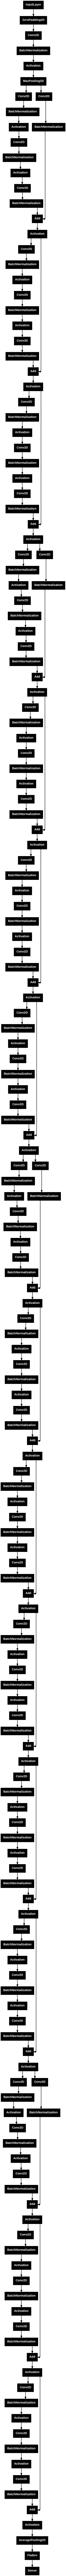

In [ ]:
plot_model(model, to_file='model.png')
#SVG(model_to_dot(model).create(prog='dot', format='svg'))

## Оценки

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, mean_absolute_error, mean_squared_error, roc_auc_score, accuracy_score

#preds = model.evaluate(X_test, Y_test)
#print ("Loss = " + str(preds[0]))
#print ("Test Accuracy = " + str(preds[1]))

# Прогнозирование на тестовых данных
Y_pred = model.predict(X_test)
Y_pred_classes = np.argmax(Y_pred, axis=1)
Y_true_classes = np.argmax(Y_test, axis=1)

# Вычисление дополнительных метрик
accuracy  = accuracy_score(Y_true_classes, Y_pred_classes)
#loss = preds[0]
precision = precision_score(Y_true_classes, Y_pred_classes, average='weighted')
recall = recall_score(Y_true_classes, Y_pred_classes, average='weighted')
f1 = f1_score(Y_true_classes, Y_pred_classes, average='weighted')
mae = mean_absolute_error(Y_test, Y_pred)
mse = mean_squared_error(Y_test, Y_pred)

#print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(accuracy))
print("Precision = " + str(precision))
print("Recall = " + str(recall))
print("F1 Score = " + str(f1))
print("Mean Absolute Error (MAE) =", mae)
print("Mean Squared Error (MSE) =", mse)

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
Test Accuracy = 0.7194208686969545
Precision = 0.6854020694525921
Recall = 0.7194208686969545
F1 Score = 0.6928574145136683
Mean Absolute Error (MAE) = 0.09631794634451239
Mean Squared Error (MSE) = 0.05455383317247655


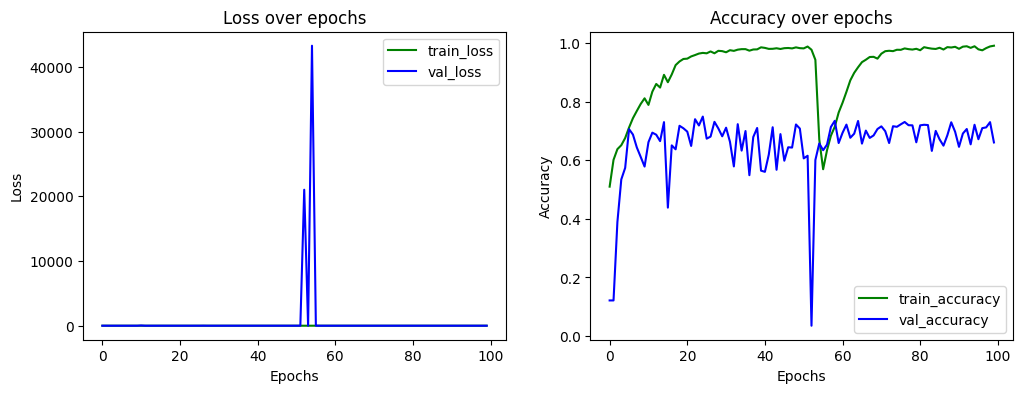

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

# Построение графиков потерь и точности
def plot_history(history):
    # График потерь
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='train_loss', color='green')
    plt.plot(history.history['val_loss'], label='val_loss', color='blue')
    plt.title('Loss over epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # График точности
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='train_accuracy', color='green')
    plt.plot(history.history['val_accuracy'], label='val_accuracy', color='blue')
    plt.title('Accuracy over epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

# Вызов функции для построения графиков
plot_history(history)

In [ ]:
model.summary()

Model: "ResNet50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 64, 64, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d            │ (None, 70, 70, 3)      │              0 │ input_layer_2[0][0]    │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1 (Conv2D)            │ (None, 32, 32, 64)     │          9,472 │ zero_padding2d[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_conv1                  │ (None, 32, 32, 64)     │            256 │ conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_6 (Activation) │ (None, 32, 32, 64)     │              0 │ bn_conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 15, 15, 64)     │              0 │ activation_6[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ res2a_branch2a (Conv2D)   │ (None, 15, 15, 64)     │          4,160 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn2a_branch2a             │ (None, 15, 15, 64)     │            256 │ res2a_branch2a[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_7 (Activation) │ (None, 15, 15, 64)     │              0 │ bn2a_branch2a[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ res2a_branch2b (Conv2D)   │ (None, 15, 15, 64)     │         36,928 │ activation_7[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn2a_branch2b             │ (None, 15, 15, 64)     │            256 │ res2a_branch2b[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_8 (Activation) │ (None, 15, 15, 64)     │              0 │ bn2a_branch2b[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ res2a_branch2c (Conv2D)   │ (None, 15, 15, 256)    │         16,640 │ activation_8[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ res2a_branch1 (Conv2D)    │ (None, 15, 15, 256)    │         16,640 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn2a_branch2c             │ (None, 15, 15, 256)    │          1,024 │ res2a_branch2c[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn2a_branch1              │ (None, 15, 15, 256)    │          1,024 │ res2a_branch1[0][0]    │
│ (BatchNormalization) 

 Total params: 23,602,057 (90.03 MB)

 Trainable params: 23,548,935 (89.83 MB)

 Non-trainable params: 53,120 (207.50 KB)

 Optimizer params: 2 (12.00 B)

### **Добавляем матрицу неточностей**

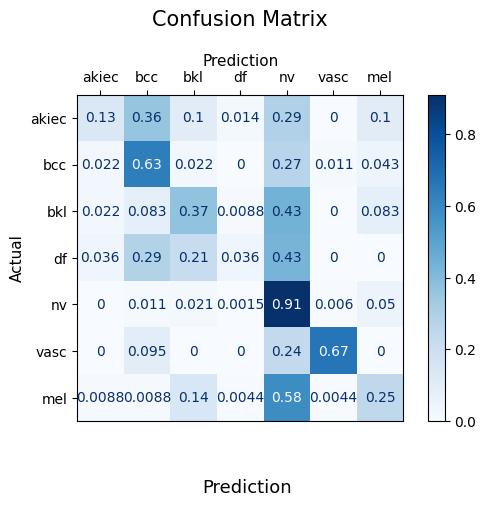

In [ ]:
# Помоги пожалуйста данные нужные вставить, если что, вот

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

class_names = ['akiec','bcc','bkl','df','nv','vasc','mel']

cm = confusion_matrix(Y_true_classes, Y_pred_classes, labels=[0, 1, 2, 3, 4, 5, 6])
row_sum = cm.sum(axis=1, keepdims=True)
cm =cm / row_sum
##np.fill_diagonal(cm, 0)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix', fontsize=15, pad=20)
plt.xlabel('Prediction', fontsize=11)
plt.ylabel('Actual', fontsize=11)
#Customizations
plt.gca().xaxis.set_label_position('top')
plt.gca().xaxis.tick_top()
plt.gca().figure.subplots_adjust(bottom=0.2)
plt.gca().figure.text(0.5, 0.05, 'Prediction', ha='center', fontsize=13)

plt.show()

In [ ]:
accuracy

0.7194208686969545

###Визуализация наших оценок в столбчатый график

Модель обучилась средне


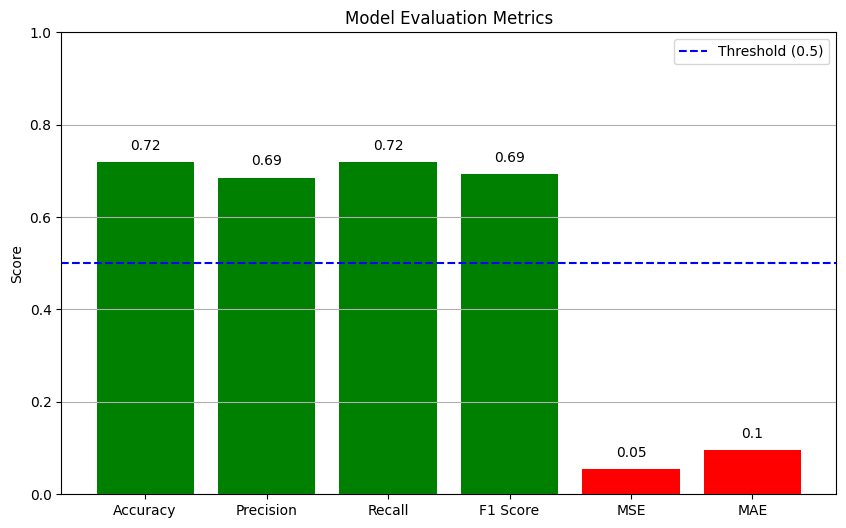

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_metrics(accuracy, precision, recall, f1_score, mse, mae):
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'MSE', 'MAE']
    values = [accuracy, precision, recall, f1_score, mse, mae]

    colors = ['green', 'green', 'green', 'green', 'red', 'red']

    plt.figure(figsize=(10, 6))
    bars = plt.bar(metrics, values, color=colors)

    plt.axhline(y=0.5, color='blue', linestyle='--', label='Threshold (0.5)')

    plt.title('Model Evaluation Metrics')
    plt.ylabel('Score')
    plt.ylim(0, max(max(values), 1))

    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 0.02, round(yval, 2), ha='center', va='bottom')

    plt.legend()
    plt.grid(axis='y')

    if accuracy >= 0.8 and precision >= 0.8 and recall >= 0.8 and f1_score >= 0.8:
        print("Модель обучилась хорошо")
    elif accuracy >= 0.5:
        print("Модель обучилась средне")
    else:
        print("Модель обучилась плохо")

    plt.show()

plot_metrics(accuracy, precision, recall, f1, mse, mae)

### Попытка построить ROC-AUC кривую

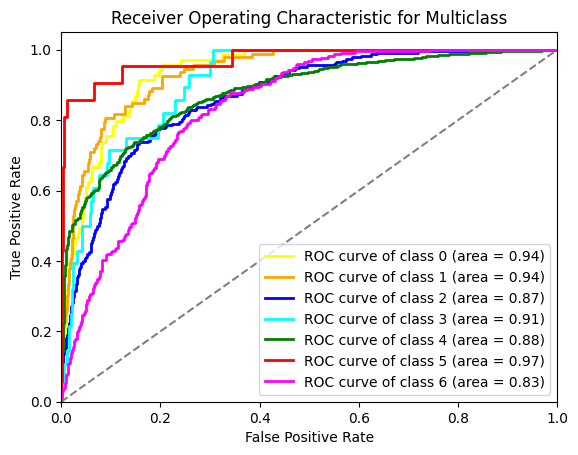

In [ ]:
from sklearn.metrics import roc_curve, auc
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(CLASSES):
    fpr[i], tpr[i], _ = roc_curve(Y_test[:, i], Y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Строим ROC-кривую
plt.figure()
colors = ['yellow', 'orange', 'blue', 'cyan', 'green', 'red', 'magenta']
for i in range(CLASSES):
    plt.plot(fpr[i], tpr[i], color=colors[i], lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Multiclass')
plt.legend(loc="lower right")
plt.show()